<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/lstm/CA_TimeSeries_LSTM_PCA_SupersetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab finds the possible 'New Cases' in some counties in California after PCA analysis 

# Mount Google Drive

In [156]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [157]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_alldatasets_Feb05.csv
 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb05.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb06.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_combined_Feb04.csv
 CA_CovidDataJan10.csv
 CA_dataset_Feb11.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb05.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb06.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Feb04.csv
 CA_processedMarylandData_Feb05.csv
 CA_processedMarylandData_Feb12.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 CA_socialDistancingInertiaData_Feb04.csv
 CA_Superset_dataset_Feb12.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Feb04.csv
 maryland_inertia_data_allstates_Feb05.csv
 maryland_inertia_data_allstates_Feb12.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Feb05.cs

In [158]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import median_absolute_error, mean_absolute_error


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


# Load superset data for CA

In [159]:
CA_superset_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_Superset_dataset_Feb12.csv',low_memory=False)
CA_superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,2020-03-01,California,6001,0,Alameda County,0.0000,3.6840,58,6.0000,9.0000,15.0000,1.0000,4.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,37,26,2.9300,25.4000,0.4000,36.8000,0.2500,2.6800,0,1666753,-5.1000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,nan,0.0000,0.0000,37,54.0000,0.0000,0.0000,0.0000,0,0,0.0500,35,1.1000,5.3000,5.7000,0.6000,0.0000
1,2020-03-02,California,6001,0,Alameda County,0.0000,6.1820,98,4.0000,7.0000,7.0000,-1.0000,3.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,17,20,3.3800,28.2000,0.4000,38.1000,0.6300,2.7400,0,1666753,-2.9000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,nan,0.0000,0.0000,38,54.0000,0.0000,0.0000,0.0000,0,0,0.0500,35,1.1000,5.3000,5.7000,0.6000,0.0000
2,2020-03-03,California,6001,1,Alameda County,0.0000,6.2710,100,5.0000,12.0000,41.0000,0.0000,1.0000,-1.0000,860.7571,California,CA,6001,Alameda County,6,16,18,3.6100,27.1000,0.3000,32.7000,0.6700,2.9400,1,1666753,4.1000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,nan,0.0002,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,1,0.0500,42,1.1000,5.3000,5.7000,0.6000,0.0000
3,2020-03-04,California,6001,0,Alameda County,0.0000,6.2090,99,1.0000,6.0000,23.0000,-3.0000,1.0000,0.0000,860.7571,California,CA,6001,Alameda County,6,14,18,3.5500,27.9000,0.3000,36.9000,0.6800,2.8700,0,1666753,1.7000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,nan,0.0002,0.0000,0,54.0000,10.3000,0.0100,0.0000,0,1,0.0600,42,1.1000,5.3000,5.7000,0.6000,0.0400
4,2020-03-05,California,6001,0,Alameda County,0.0000,6.6540,106,1.0000,6.0000,12.0000,-5.0000,-1.0000,1.0000,860.7571,California,CA,6001,Alameda County,6,15,19,3.5400,28.1000,0.3000,36.8000,0.6600,2.8800,0,1666753,2.0000,15.0400,19,92574,10.5000,22.5000,49.1100,1155,131,2.0500,0.2200,nan,0.0002,0.0000,0,54.0000,10.3000,0.0100,0.0000,0,1,0.0600,42,1.1000,5.3000,5.7000,0.6000,0.0400


## Group the data

In [160]:
CA_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'State', 'CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.peop

In [161]:
x_col_demographics = ['PopDensity','X..people.older.than.60',
                      'Median.income', 'X..African.Americans',
                      'X..Hispanic.Americans', 'X..Male','Date','New cases']

In [162]:
x_col_hospitalization_testing = ['Hospital.beds.1000.people',
       'ICUs.1000.people', 
       'X..hospital.bed.utilization',
       'Testing.capacity', 'Tests.done.1000.people', 'X..ICU.utilization',
       'Ventilator.shortage','Date','New cases'] #'X..contact.tracing.workers.1000.people',

In [163]:
x_col_mobility = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person','X..working.from.home','Date','New cases']

In [164]:
x_col_socialdistancing = ['m50', 'm50_index','Social.distancing.index','Date','New cases']

In [165]:
x_col_maskrule = ['mask_rule_severity','Date','New cases']

# LSTM: Demographic Group

In [166]:
X_cols_all = x_col_demographics

X_cols_feature_selected = ['X..people.older.than.60', 'Median.income', 'X..Male',
                           'X..African.Americans', 'PopDensity'
                           ,'Date','New cases']


In [167]:
LA_combined_data_all = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(292, 8)
(292, 7)


,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Date,New cases
4804,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-01,0
4805,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-02,0
4806,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-03,0
4807,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-04,6
4808,960.7428,18,64251,7.9000,48.5000,49.2800,2020-03-05,4


In [168]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [169]:
len(LA_combined_data_featured.columns)

7

In [170]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,X..people.older.than.60,Median.income,X..Male,X..African.Americans,PopDensity,Date,New cases
4804,18,64251,49.2800,7.9000,960.7428,1583020800.0000,0
4805,18,64251,49.2800,7.9000,960.7428,1583107200.0000,0
4806,18,64251,49.2800,7.9000,960.7428,1583193600.0000,0
4807,18,64251,49.2800,7.9000,960.7428,1583280000.0000,6
4808,18,64251,49.2800,7.9000,960.7428,1583366400.0000,4


In [171]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

7


X..people.older.than.60      int64
Median.income                int64
X..Male                    float64
X..African.Americans       float64
PopDensity                 float64
Date                       float64
New cases                    int64
dtype: object

## Preprocessing data for LSTM

In [172]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [173]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [174]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t)  var7(t)  var8(t)
1     0.0000     0.0000     0.0000  ...   0.0000   0.0033   0.0000
2     0.0000     0.0000     0.0000  ...   0.0000   0.0066   0.0000
3     0.0000     0.0000     0.0000  ...   0.0000   0.0099   0.0186
4     0.0000     0.0000     0.0000  ...   0.0000   0.0132   0.0112
5     0.0000     0.0000     0.0000  ...   0.0000   0.0166   0.0074

[5 rows x 16 columns]


## Train Test Split

In [175]:
values.shape[0]

292

In [176]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 16)
(232, 1, 15) (232,) (59, 1, 15) (59,)


## Training LSTM

Epoch 1/100
4/4 - 3s - loss: 0.3474 - val_loss: 0.6384
Epoch 2/100
4/4 - 0s - loss: 0.3244 - val_loss: 0.5984
Epoch 3/100
4/4 - 0s - loss: 0.3024 - val_loss: 0.5586
Epoch 4/100
4/4 - 0s - loss: 0.2810 - val_loss: 0.5189
Epoch 5/100
4/4 - 0s - loss: 0.2602 - val_loss: 0.4792
Epoch 6/100
4/4 - 0s - loss: 0.2412 - val_loss: 0.4403
Epoch 7/100
4/4 - 0s - loss: 0.2251 - val_loss: 0.4031
Epoch 8/100
4/4 - 0s - loss: 0.2108 - val_loss: 0.3676
Epoch 9/100
4/4 - 0s - loss: 0.1995 - val_loss: 0.3347
Epoch 10/100
4/4 - 0s - loss: 0.1907 - val_loss: 0.3073
Epoch 11/100
4/4 - 0s - loss: 0.1847 - val_loss: 0.2846
Epoch 12/100
4/4 - 0s - loss: 0.1808 - val_loss: 0.2667
Epoch 13/100
4/4 - 0s - loss: 0.1783 - val_loss: 0.2545
Epoch 14/100
4/4 - 0s - loss: 0.1767 - val_loss: 0.2468
Epoch 15/100
4/4 - 0s - loss: 0.1755 - val_loss: 0.2423
Epoch 16/100
4/4 - 0s - loss: 0.1747 - val_loss: 0.2410
Epoch 17/100
4/4 - 0s - loss: 0.1742 - val_loss: 0.2416
Epoch 18/100
4/4 - 0s - loss: 0.1738 - val_loss: 0.2430
E

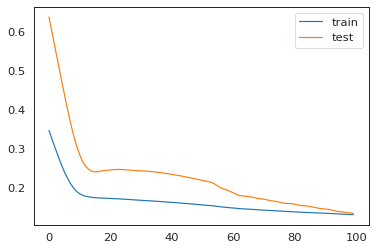

In [177]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

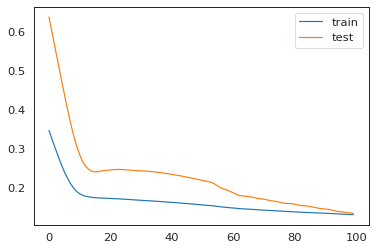

In [178]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [179]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 15)
Test MSE: 0.042
Test RMSE: 0.204
median_absolute_error 0.10000414
mean_absolute_error 0.13449013


## Preprocessing feature selected data for training

In [180]:
len(LA_combined_data_featured_selected.columns)

7

In [181]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_feature_selected)-1] = encoder.fit_transform(values[:,len(X_cols_feature_selected)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var5(t)  var6(t)  var7(t)
1     0.0000     0.0000     0.0000  ...   0.0000   0.0033   0.0000
2     0.0000     0.0000     0.0000  ...   0.0000   0.0066   0.0000
3     0.0000     0.0000     0.0000  ...   0.0000   0.0099   0.0186
4     0.0000     0.0000     0.0000  ...   0.0000   0.0132   0.0112
5     0.0000     0.0000     0.0000  ...   0.0000   0.0166   0.0074

[5 rows x 14 columns]


### Train Test split

In [182]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 14)
(232, 1, 13) (232,) (59, 1, 13) (59,)


### Training LSTM for feature selected data

In [183]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
4/4 - 2s - loss: 0.3905 - val_loss: 0.7309
Epoch 2/200
4/4 - 0s - loss: 0.3665 - val_loss: 0.6923
Epoch 3/200
4/4 - 0s - loss: 0.3437 - val_loss: 0.6535
Epoch 4/200
4/4 - 0s - loss: 0.3222 - val_loss: 0.6145
Epoch 5/200
4/4 - 0s - loss: 0.3015 - val_loss: 0.5752
Epoch 6/200
4/4 - 0s - loss: 0.2818 - val_loss: 0.5371
Epoch 7/200
4/4 - 0s - loss: 0.2629 - val_loss: 0.4985
Epoch 8/200
4/4 - 0s - loss: 0.2450 - val_loss: 0.4611
Epoch 9/200
4/4 - 0s - loss: 0.2293 - val_loss: 0.4247
Epoch 10/200
4/4 - 0s - loss: 0.2156 - val_loss: 0.3898
Epoch 11/200
4/4 - 0s - loss: 0.2040 - val_loss: 0.3577
Epoch 12/200
4/4 - 0s - loss: 0.1957 - val_loss: 0.3296
Epoch 13/200
4/4 - 0s - loss: 0.1895 - val_loss: 0.3062
Epoch 14/200
4/4 - 0s - loss: 0.1851 - val_loss: 0.2868
Epoch 15/200
4/4 - 0s - loss: 0.1822 - val_loss: 0.2718
Epoch 16/200
4/4 - 0s - loss: 0.1802 - val_loss: 0.2615
Epoch 17/200
4/4 - 0s - loss: 0.1788 - val_loss: 0.2551
Epoch 18/200
4/4 - 0s - loss: 0.1778 - val_loss: 0.2513
E

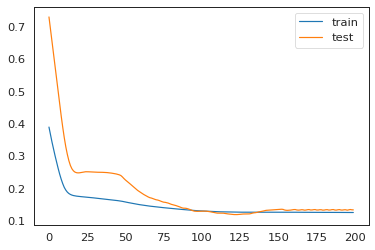

In [184]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [185]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 13)
Test MSE: 0.048
Test RMSE: 0.220
median_absolute_error 0.0847283
mean_absolute_error 0.13449872


# LSTM: Hospitalization and testing Group

In [186]:


X_cols_all = x_col_hospitalization_testing

X_cols_feature_selected = ['X..hospital.bed.utilization', 'Testing.capacity','Tests.done.1000.people'
                           ,'Date','New cases']


In [187]:
LA_combined_data_all = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(292, 9)
(292, 5)


,Hospital.beds.1000.people,ICUs.1000.people,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Date,New cases
4804,2.0500,0.2200,54.0000,0.0000,0.0000,0.0000,0,2020-03-01,0
4805,2.0500,0.2200,54.0000,0.0000,0.0000,0.0000,0,2020-03-02,0
4806,2.0500,0.2200,54.0000,0.0000,0.0000,0.0000,0,2020-03-03,0
4807,2.0500,0.2200,54.0000,10.3000,0.0100,0.0000,0,2020-03-04,6
4808,2.0500,0.2200,54.0000,10.3000,0.0100,0.0000,0,2020-03-05,4


In [188]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [189]:
len(LA_combined_data_featured.columns)

5

In [190]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,Date,New cases
4804,54.0000,0.0000,0.0000,1583020800.0000,0
4805,54.0000,0.0000,0.0000,1583107200.0000,0
4806,54.0000,0.0000,0.0000,1583193600.0000,0
4807,54.0000,10.3000,0.0100,1583280000.0000,6
4808,54.0000,10.3000,0.0100,1583366400.0000,4


In [191]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

5


X..hospital.bed.utilization    float64
Testing.capacity               float64
Tests.done.1000.people         float64
Date                           float64
New cases                        int64
dtype: object

## Preprocessing data for LSTM

In [192]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [193]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [194]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t)  var8(t)  var9(t)
1     0.0000     0.0000     0.0000  ...   0.0000   0.0033   0.0000
2     0.0000     0.0000     0.0000  ...   0.0000   0.0066   0.0000
3     0.0000     0.0000     0.0000  ...   0.0000   0.0099   0.0186
4     0.0000     0.0000     0.0000  ...   0.0000   0.0132   0.0112
5     0.0000     0.0000     0.0000  ...   0.0003   0.0166   0.0074

[5 rows x 18 columns]


## Train Test Split

In [195]:
values.shape[0]

292

In [196]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 18)
(232, 1, 17) (232,) (59, 1, 17) (59,)


## Training LSTM

Epoch 1/100
4/4 - 2s - loss: 0.3905 - val_loss: 0.6615
Epoch 2/100
4/4 - 0s - loss: 0.3482 - val_loss: 0.5904
Epoch 3/100
4/4 - 0s - loss: 0.3104 - val_loss: 0.5209
Epoch 4/100
4/4 - 0s - loss: 0.2745 - val_loss: 0.4503
Epoch 5/100
4/4 - 0s - loss: 0.2418 - val_loss: 0.3821
Epoch 6/100
4/4 - 0s - loss: 0.2164 - val_loss: 0.3180
Epoch 7/100
4/4 - 0s - loss: 0.1983 - val_loss: 0.2628
Epoch 8/100
4/4 - 0s - loss: 0.1870 - val_loss: 0.2187
Epoch 9/100
4/4 - 0s - loss: 0.1795 - val_loss: 0.1901
Epoch 10/100
4/4 - 0s - loss: 0.1748 - val_loss: 0.1777
Epoch 11/100
4/4 - 0s - loss: 0.1718 - val_loss: 0.1726
Epoch 12/100
4/4 - 0s - loss: 0.1695 - val_loss: 0.1713
Epoch 13/100
4/4 - 0s - loss: 0.1674 - val_loss: 0.1727
Epoch 14/100
4/4 - 0s - loss: 0.1655 - val_loss: 0.1751
Epoch 15/100
4/4 - 0s - loss: 0.1637 - val_loss: 0.1781
Epoch 16/100
4/4 - 0s - loss: 0.1620 - val_loss: 0.1817
Epoch 17/100
4/4 - 0s - loss: 0.1603 - val_loss: 0.1855
Epoch 18/100
4/4 - 0s - loss: 0.1586 - val_loss: 0.1892
E

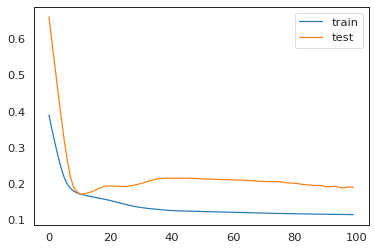

In [197]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

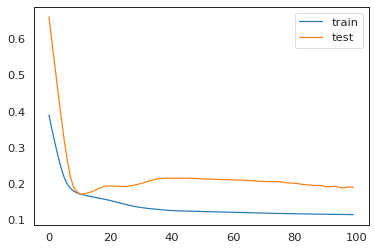

In [198]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [199]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 17)
Test MSE: 0.058
Test RMSE: 0.241
median_absolute_error 0.17896634
mean_absolute_error 0.18997414


## Preprocessing feature selected data for training

In [200]:
len(LA_combined_data_featured_selected.columns)

5

In [201]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_feature_selected)-1] = encoder.fit_transform(values[:,len(X_cols_feature_selected)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var3(t)  var4(t)  var5(t)
1     0.0000     0.0000     0.0000  ...   0.0000   0.0033   0.0000
2     0.0000     0.0000     0.0000  ...   0.0000   0.0066   0.0000
3     0.0000     0.0000     0.0000  ...   0.0000   0.0099   0.0186
4     0.0000     0.3399     0.0000  ...   0.0000   0.0132   0.0112
5     0.0000     0.3399     0.0000  ...   0.0000   0.0166   0.0074

[5 rows x 10 columns]


### Train Test split

In [202]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 10)
(232, 1, 9) (232,) (59, 1, 9) (59,)


### Training LSTM for feature selected data

In [203]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
4/4 - 2s - loss: 0.3537 - val_loss: 0.6325
Epoch 2/200
4/4 - 0s - loss: 0.3228 - val_loss: 0.5758
Epoch 3/200
4/4 - 0s - loss: 0.2947 - val_loss: 0.5192
Epoch 4/200
4/4 - 0s - loss: 0.2676 - val_loss: 0.4620
Epoch 5/200
4/4 - 0s - loss: 0.2437 - val_loss: 0.4067
Epoch 6/200
4/4 - 0s - loss: 0.2251 - val_loss: 0.3545
Epoch 7/200
4/4 - 0s - loss: 0.2114 - val_loss: 0.3076
Epoch 8/200
4/4 - 0s - loss: 0.2015 - val_loss: 0.2695
Epoch 9/200
4/4 - 0s - loss: 0.1953 - val_loss: 0.2402
Epoch 10/200
4/4 - 0s - loss: 0.1916 - val_loss: 0.2202
Epoch 11/200
4/4 - 0s - loss: 0.1892 - val_loss: 0.2090
Epoch 12/200
4/4 - 0s - loss: 0.1876 - val_loss: 0.2037
Epoch 13/200
4/4 - 0s - loss: 0.1863 - val_loss: 0.2025
Epoch 14/200
4/4 - 0s - loss: 0.1852 - val_loss: 0.2039
Epoch 15/200
4/4 - 0s - loss: 0.1842 - val_loss: 0.2071
Epoch 16/200
4/4 - 0s - loss: 0.1834 - val_loss: 0.2113
Epoch 17/200
4/4 - 0s - loss: 0.1826 - val_loss: 0.2159
Epoch 18/200
4/4 - 0s - loss: 0.1820 - val_loss: 0.2203
E

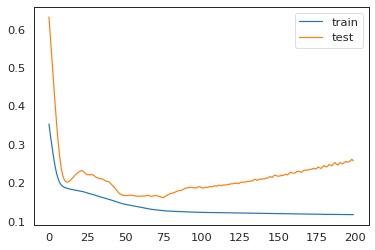

In [204]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [205]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 9)
Test MSE: 0.087
Test RMSE: 0.294
median_absolute_error 0.26729965
mean_absolute_error 0.25848734


# LSTM: Mobility Group + Social Distancing + Mask Rule

In [206]:
x_col_mobility = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person','X..working.from.home',
       'm50', 'm50_index','Social.distancing.index',
                           'mask_rule_severity',
       'Date','New cases']

X_cols_all = x_col_mobility

X_cols_feature_selected = ['X..staying.home', 'X..working.from.home', 'workplaces_percent_change_from_baseline', 
                           'X..out.of.state.trips', 'parks_percent_change_from_baseline',
                           'm50', 'm50_index','Social.distancing.index',
                           'mask_rule_severity'
                           ,'Date','New cases']


In [207]:
LA_combined_data_all = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_featured = CA_superset_data[CA_superset_data['County Name'] == 'Los Angeles County'][X_cols_feature_selected]
print(LA_combined_data_featured.shape)
LA_combined_data_all.head(5)

(292, 20)
(292, 11)


,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..working.from.home,m50,m50_index,Social.distancing.index,mask_rule_severity,Date,New cases
4804,4.0000,3.0000,-5.0000,-3.0000,1.0000,0.0000,26,2.9100,11.2000,0.5000,35.1000,0.2600,2.6500,5.7000,3.9960,60,35,0.0000,2020-03-01,0
4805,5.0000,5.0000,8.0000,1.0000,4.0000,-1.0000,19,3.4200,10.4000,0.4000,35.1000,0.7000,2.7100,5.7000,6.5020,98,16,0.0000,2020-03-02,0
4806,8.0000,7.0000,32.0000,2.0000,3.0000,-1.0000,18,3.5700,10.2000,0.3000,33.7000,0.7300,2.8400,5.7000,6.5910,99,15,0.0000,2020-03-03,0
4807,4.0000,6.0000,9.0000,-1.0000,2.0000,0.0000,18,3.4800,10.7000,0.3000,34.9000,0.7200,2.7600,5.7000,6.5950,100,14,0.0000,2020-03-04,6
4808,4.0000,7.0000,9.0000,0.0000,2.0000,0.0000,18,3.5200,10.7000,0.3000,36.4000,0.7200,2.8100,5.7000,7.0080,106,14,0.0000,2020-03-05,4


In [208]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [209]:
len(LA_combined_data_featured.columns)

11

In [210]:
LA_combined_data_featured['Date'] = LA_combined_data_featured['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_featured.head()

,X..staying.home,X..working.from.home,workplaces_percent_change_from_baseline,X..out.of.state.trips,parks_percent_change_from_baseline,m50,m50_index,Social.distancing.index,mask_rule_severity,Date,New cases
4804,26,5.7000,1.0000,0.5000,-5.0000,3.9960,60,35,0.0000,1583020800.0000,0
4805,19,5.7000,4.0000,0.4000,8.0000,6.5020,98,16,0.0000,1583107200.0000,0
4806,18,5.7000,3.0000,0.3000,32.0000,6.5910,99,15,0.0000,1583193600.0000,0
4807,18,5.7000,2.0000,0.3000,9.0000,6.5950,100,14,0.0000,1583280000.0000,6
4808,18,5.7000,2.0000,0.3000,9.0000,7.0080,106,14,0.0000,1583366400.0000,4


In [211]:
print(len(LA_combined_data_featured.columns))
LA_combined_data_featured.dtypes

11


X..staying.home                              int64
X..working.from.home                       float64
workplaces_percent_change_from_baseline    float64
X..out.of.state.trips                      float64
parks_percent_change_from_baseline         float64
m50                                        float64
m50_index                                    int64
Social.distancing.index                      int64
mask_rule_severity                         float64
Date                                       float64
New cases                                    int64
dtype: object

## Preprocessing data for LSTM

In [212]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_featured_selected = LA_combined_data_featured[X_cols_feature_selected]

In [213]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

In [214]:
values = LA_combined_data_all_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_all)-1] = encoder.fit_transform(values[:,len(X_cols_all)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var18(t)  var19(t)  var20(t)
1     0.9512     0.6092     0.6337  ...    0.0000    0.0033    0.0000
2     0.9634     0.6322     0.7624  ...    0.0000    0.0066    0.0000
3     1.0000     0.6552     1.0000  ...    0.0000    0.0099    0.0186
4     0.9512     0.6437     0.7723  ...    0.0000    0.0132    0.0112
5     0.9512     0.6552     0.7723  ...    0.0000    0.0166    0.0074

[5 rows x 40 columns]


## Train Test Split

In [215]:
values.shape[0]

292

In [216]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 40)
(232, 1, 39) (232,) (59, 1, 39) (59,)


## Training LSTM

Epoch 1/100
4/4 - 2s - loss: 0.3977 - val_loss: 0.5811
Epoch 2/100
4/4 - 0s - loss: 0.2281 - val_loss: 0.3946
Epoch 3/100
4/4 - 0s - loss: 0.1742 - val_loss: 0.2935
Epoch 4/100
4/4 - 0s - loss: 0.1837 - val_loss: 0.2696
Epoch 5/100
4/4 - 0s - loss: 0.1855 - val_loss: 0.2896
Epoch 6/100
4/4 - 0s - loss: 0.1781 - val_loss: 0.3301
Epoch 7/100
4/4 - 0s - loss: 0.1740 - val_loss: 0.3725
Epoch 8/100
4/4 - 0s - loss: 0.1745 - val_loss: 0.3977
Epoch 9/100
4/4 - 0s - loss: 0.1760 - val_loss: 0.4017
Epoch 10/100
4/4 - 0s - loss: 0.1734 - val_loss: 0.3887
Epoch 11/100
4/4 - 0s - loss: 0.1683 - val_loss: 0.3691
Epoch 12/100
4/4 - 0s - loss: 0.1638 - val_loss: 0.3494
Epoch 13/100
4/4 - 0s - loss: 0.1601 - val_loss: 0.3352
Epoch 14/100
4/4 - 0s - loss: 0.1577 - val_loss: 0.3336
Epoch 15/100
4/4 - 0s - loss: 0.1557 - val_loss: 0.3398
Epoch 16/100
4/4 - 0s - loss: 0.1541 - val_loss: 0.3467
Epoch 17/100
4/4 - 0s - loss: 0.1521 - val_loss: 0.3452
Epoch 18/100
4/4 - 0s - loss: 0.1496 - val_loss: 0.3340
E

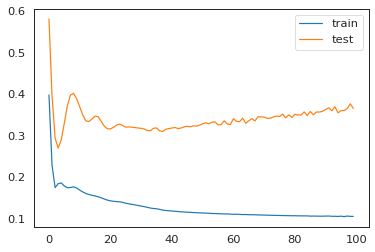

In [217]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

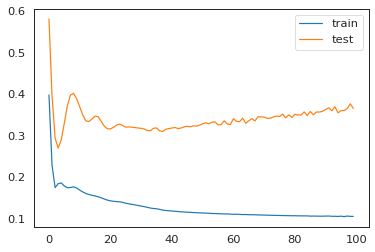

In [218]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test

In [219]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 39)
Test MSE: 0.158
Test RMSE: 0.398
median_absolute_error 0.3735332
mean_absolute_error 0.36524585


## Preprocessing feature selected data for training

In [220]:
len(LA_combined_data_featured_selected.columns)

11

In [221]:
values = LA_combined_data_featured_selected.values
# integer encode direction
encoder = LabelEncoder()
values[:,len(X_cols_feature_selected)-1] = encoder.fit_transform(values[:,len(X_cols_feature_selected)-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var9(t)  var10(t)  var11(t)
1     0.2353     0.0000     0.9655  ...   0.0000    0.0033    0.0000
2     0.0294     0.0000     1.0000  ...   0.0000    0.0066    0.0000
3     0.0000     0.0000     0.9885  ...   0.0000    0.0099    0.0186
4     0.0000     0.0000     0.9770  ...   0.0000    0.0132    0.0112
5     0.0000     0.0000     0.9770  ...   0.0000    0.0166    0.0074

[5 rows x 22 columns]


### Train Test split

In [222]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

232
values shape  (291, 22)
(232, 1, 21) (232,) (59, 1, 21) (59,)


### Training LSTM for feature selected data

In [223]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
4/4 - 2s - loss: 0.4418 - val_loss: 0.7280
Epoch 2/200
4/4 - 0s - loss: 0.3447 - val_loss: 0.6146
Epoch 3/200
4/4 - 0s - loss: 0.2674 - val_loss: 0.5053
Epoch 4/200
4/4 - 0s - loss: 0.2121 - val_loss: 0.4134
Epoch 5/200
4/4 - 0s - loss: 0.1860 - val_loss: 0.3447
Epoch 6/200
4/4 - 0s - loss: 0.1807 - val_loss: 0.3047
Epoch 7/200
4/4 - 0s - loss: 0.1807 - val_loss: 0.2906
Epoch 8/200
4/4 - 0s - loss: 0.1799 - val_loss: 0.2934
Epoch 9/200
4/4 - 0s - loss: 0.1782 - val_loss: 0.3062
Epoch 10/200
4/4 - 0s - loss: 0.1766 - val_loss: 0.3237
Epoch 11/200
4/4 - 0s - loss: 0.1757 - val_loss: 0.3421
Epoch 12/200
4/4 - 0s - loss: 0.1757 - val_loss: 0.3578
Epoch 13/200
4/4 - 0s - loss: 0.1758 - val_loss: 0.3665
Epoch 14/200
4/4 - 0s - loss: 0.1756 - val_loss: 0.3673
Epoch 15/200
4/4 - 0s - loss: 0.1741 - val_loss: 0.3622
Epoch 16/200
4/4 - 0s - loss: 0.1719 - val_loss: 0.3532
Epoch 17/200
4/4 - 0s - loss: 0.1694 - val_loss: 0.3434
Epoch 18/200
4/4 - 0s - loss: 0.1670 - val_loss: 0.3361
E

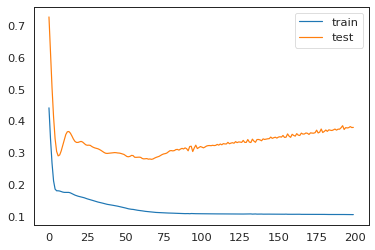

In [224]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [225]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(59, 21)
Test MSE: 0.178
Test RMSE: 0.422
median_absolute_error 0.39813504
mean_absolute_error 0.38025996


# Conclusion for all dataset after PCA

| data | MSE  |RMSE  |Median AE  |MAE|
|------|------|-----|------|-----|
|   without PCA  | 0.117| 0.342|0.335|0.315|
|   with PCA  | 0.085| 0.291|0.272|0.264|